# The Simpsons classification

## Requirements

In [62]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split,SubsetRandomSampler
#import torchvision
from torchvision.datasets import ImageFolder
import torchinfo
from torchmetrics import F1Score
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters and constants

In [63]:
lr = 0.005
batch_size = 32
epochs = 20

class_number = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_names = ['abraham_grampa_simpson',
            'agnes_skinner',
            'apu_nahasapeemapetilon',
            'barney_gumble',
            'bart_simpson',
            'carl_carlson',
            'charles_montgomery_burns',
            'chief_wiggum',
            'cletus_spuckler',
            'comic_book_guy',
            'disco_stu',
            'edna_krabappel',
            'fat_tony',
            'gil',
            'groundskeeper_willie',
            'homer_simpson',
            'kent_brockman',
            'krusty_the_clown',
            'lenny_leonard',
            'lionel_hutz',
            'lisa_simpson',
            'maggie_simpson',
            'marge_simpson',
            'martin_prince',
            'mayor_quimby',
            'milhouse_van_houten',
            'miss_hoover',
            'moe_szyslak',
            'ned_flanders',
            'nelson_muntz',
            'otto_mann',
            'patty_bouvier',
            'principal_skinner',
            'professor_john_frink',
            'rainier_wolfcastle',
            'ralph_wiggum',
            'selma_bouvier',
            'sideshow_bob',
            'sideshow_mel',
            'snake_jailbird',
            'troy_mcclure',
            'waylon_smithers']

## NN model

In [64]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 42)

        self.train_losses = []
        self.test_accs = []

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.pool(output)
        output = output.view(-1, 512)
        output = self.fc1(output)
        return output

    def saveModel(self, filename='./simpsons_model.pth'):
        torch.save(obj=self.state_dict(), f=filename)

    def train(self, optimizer, train_loader, criterion, epochs):
        print('Training started')
        steps_number = len(train_loader)
        
        for epoch in range(epochs):
            running_loss = 0.0
            for step, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                
                #зануление градиентов
                optimizer.zero_grad()

                #форвард
                outputs = self(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()

                running_loss += loss.item()
                
                #лог
                if step % 100 == 99:
                    print(f'[{epoch + 1}, {step + 1:5d}] loss: {loss.item():.3f}')
            self.train_losses.append(running_loss/steps_number)
            
        print('Training finished')

    def test(self, test_loader):
        print('Testing started')
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

        avg_f1 = F1Score(task="multiclass", num_classes=42).to(device)
        class_f1 =F1Score(task="multiclass", num_classes=42,average=None).to(device)
        
        #градиенты на тесте считать уже не нужно
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = self(images)

                _, predicted = torch.max(outputs.data, 1)
                   
                avg_f1.update(predicted,labels)
                class_f1.update(predicted,labels)
                
        self.test_accs = class_f1.compute() 
        
        print('Testing finished')     
        print(f"F1(torchmetrics): {avg_f1.compute():.3%}")
        

In [ ]:
model = Network()
model.to(device)

## Optimizer and Loss function

In [65]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Data dividing

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
                                                torchvision.transforms.Resize((32,32))])
dataset = ImageFolder(
    "The Simpsons Characters Data/simpsons_dataset/simpsons_dataset", transform=transform)


#stratified split
from sklearn.model_selection import train_test_split
targets = dataset.targets
train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets
)

train_sampler =SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size, num_workers=2,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, num_workers=2,sampler = test_sampler)

## Training

In [67]:
model.train(optimizer,train_loader,criterion,epochs)

Training started
[1,   100] loss: 2.889
[1,   200] loss: 2.038
[1,   300] loss: 2.429
[1,   400] loss: 1.941
[1,   500] loss: 1.657
[2,   100] loss: 1.325
[2,   200] loss: 0.951
[2,   300] loss: 1.243
[2,   400] loss: 1.115
[2,   500] loss: 1.254
[3,   100] loss: 1.194
[3,   200] loss: 0.943
[3,   300] loss: 1.071
[3,   400] loss: 0.703
[3,   500] loss: 0.859
[4,   100] loss: 0.823
[4,   200] loss: 0.806
[4,   300] loss: 0.550
[4,   400] loss: 0.484
[4,   500] loss: 0.586
[5,   100] loss: 0.381
[5,   200] loss: 0.578
[5,   300] loss: 0.602
[5,   400] loss: 0.291
[5,   500] loss: 0.782
[6,   100] loss: 0.175
[6,   200] loss: 0.518
[6,   300] loss: 1.013
[6,   400] loss: 0.756
[6,   500] loss: 0.294
[7,   100] loss: 0.797
[7,   200] loss: 0.339
[7,   300] loss: 0.510
[7,   400] loss: 0.460
[7,   500] loss: 0.336
[8,   100] loss: 0.497
[8,   200] loss: 0.327
[8,   300] loss: 0.323
[8,   400] loss: 0.517
[8,   500] loss: 0.330
[9,   100] loss: 0.202
[9,   200] loss: 0.367
[9,   300] loss: 

Text(0, 0.5, 'Loss')

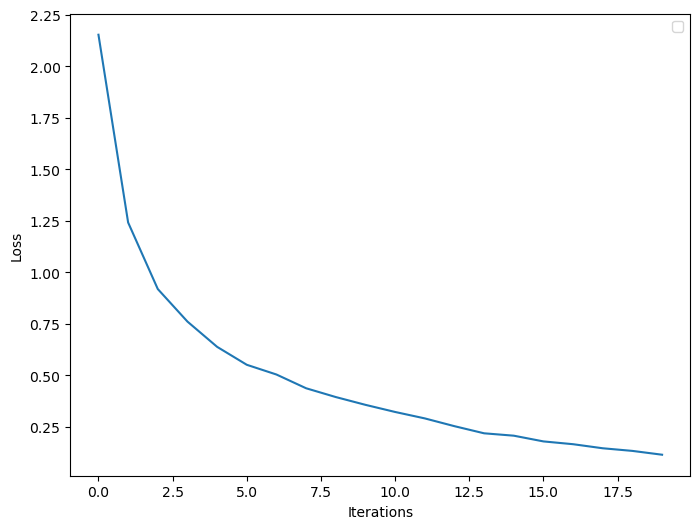

In [68]:
fig = plt.figure(figsize=(8, 6))
plt.plot(model.train_losses)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Testing

In [69]:
model.saveModel()
#model.test(test_loader)

In [ ]:
net = Network().to(device)
net.load_state_dict(torch.load("/simpsons_model.pth"))

In [71]:
net.test(test_loader)

Testing started
Testing finished
F1(torchmetrics): 90.996%


<BarContainer object of 42 artists>

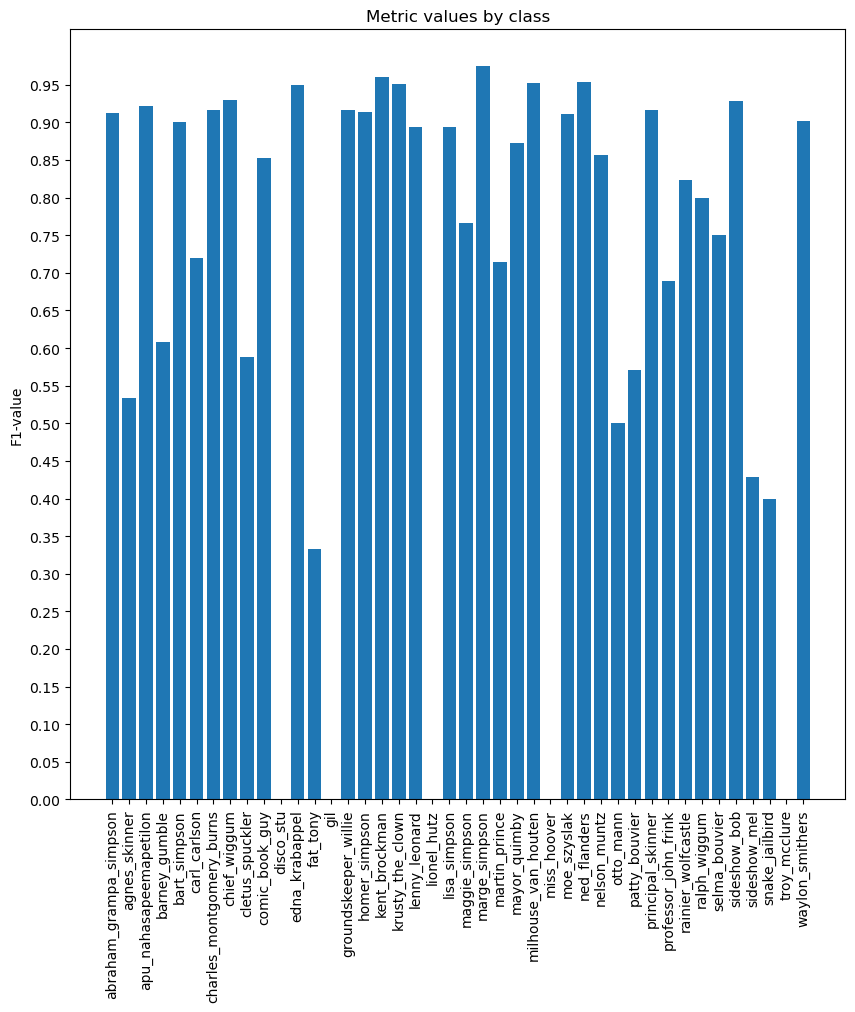

In [72]:
bar = plt.figure(figsize=(10,10))
plt.title("Metric values by class")
plt.ylabel('F1-value')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0, 1.00, 0.05))
plt.bar(class_names, np.array(net.test_accs.cpu()))